In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-07-15 14:50:55.458357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752616255.472241  403473 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752616255.476532  403473 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752616255.488802  403473 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752616255.488813  403473 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752616255.488815  403473 computation_placer.cc:177] computation placer alr

In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [3]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [4]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


In [9]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable
import h5py

# === Custom Components ===
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

@register_keras_serializable(package="Custom")
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )

# === Load Reference ===
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    ref_d = file['density'][:]  # shape: (64, 64, 64)
minorized_ref_d = np.sum(ref_d, axis=2)  # shape: (64, 64)

# === Load UNet Model ===
unet_model_path = "UNet_Denoiser.keras"
if os.path.exists(unet_model_path):
    unet = load_model(unet_model_path, compile=False)
    print("U-Net model loaded.")
else:
    print("U-Net model not found.")
    unet = None

# === Find Models and Match to Sample Sizes ===
model_files = [f for f in os.listdir('.') if re.match(r'\d+_(DAE|CAE)\.keras$', f)]
model_dict = {}
for f in model_files:
    match = re.match(r'(\d+)_(DAE|CAE)\.keras$', f)
    if match:
        n, model_type = match.groups()
        n = int(n)
        if n not in model_dict:
            model_dict[n] = {}
        model_dict[n][model_type] = f

# === JSD Arrays ===
n_values = []
dae_jsd = []
cae_jsd = []
unet_jsd = []
avg_sample_jsd = []

# === Main Loop ===
for n_samples in sorted(model_dict.keys()):
    print(n_samples)
    models = model_dict[n_samples]
    sample_file = f"{n_samples}_sample_density.npy"

    if 'DAE' not in models or 'CAE' not in models:
        print(f"Skipping {n_samples}: Missing DAE or CAE model.")
        continue
    if not os.path.exists(sample_file):
        print(f"Skipping {n_samples}: Sample file not found.")
        continue

    # Load models and data
    dae = load_model(models['DAE'], compile=False)
    cae = load_model(models['CAE'], compile=False)
    avg_sample = np.load(sample_file)  # shape (64, 64)

    avg_sample_reshaped = avg_sample.reshape(-1, 64, 64, 1)
    dae_pred = dae.predict(avg_sample_reshaped)[0, :, :, 0]
    cae_pred = cae.predict(avg_sample_reshaped)[0, :, :, 0]

    if unet is not None:
        unet_pred = unet.predict(avg_sample_reshaped)[0, :, :, 0]
        jsd_unet = jensen_shannon_divergence_loss(unet_pred, minorized_ref_d).numpy()
    else:
        jsd_unet = np.nan

    # Compute JSDs
    jsd_dae = jensen_shannon_divergence_loss(dae_pred, minorized_ref_d).numpy()
    jsd_cae = jensen_shannon_divergence_loss(cae_pred, minorized_ref_d).numpy()
    jsd_avg = jensen_shannon_divergence_loss(avg_sample, minorized_ref_d).numpy()

    # Store
    n_values.append(n_samples)
    dae_jsd.append(jsd_dae)
    cae_jsd.append(jsd_cae)
    unet_jsd.append(jsd_unet)
    avg_sample_jsd.append(jsd_avg)


U-Net model loaded.
22684000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
22922000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
114815000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
115565000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
229090000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1148900000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2309400000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
11511500000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━

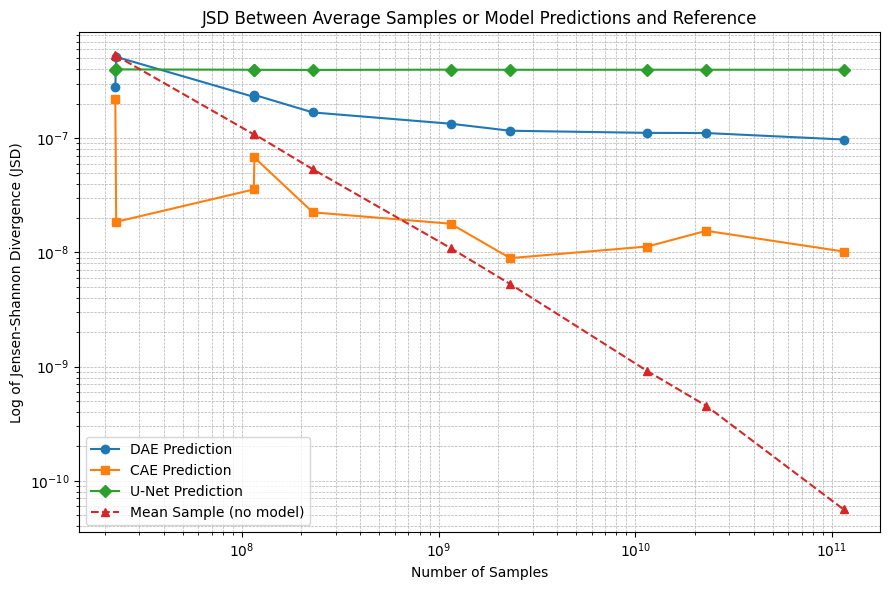

In [10]:
# === Plotting in Jupyter ===
plt.figure(figsize=(9, 6))
plt.loglog(n_values, dae_jsd, marker='o', label='DAE Prediction')
plt.loglog(n_values, cae_jsd, marker='s', label='CAE Prediction')
plt.loglog(n_values, unet_jsd, marker='D', label='U-Net Prediction')  # <-- Added U-Net here
plt.loglog(n_values, avg_sample_jsd, marker='^', linestyle='--', label='Mean Sample (no model)')

plt.xlabel("Number of Samples")
plt.ylabel("Log of Jensen-Shannon Divergence (JSD)")
plt.title("JSD Between Average Samples or Model Predictions and Reference")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


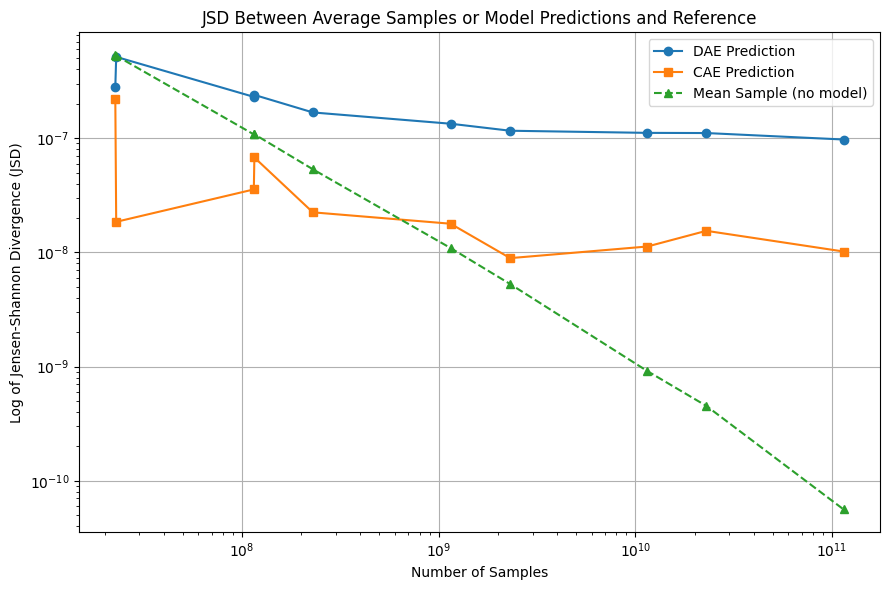

In [11]:
# === Plotting in Jupyter ===
plt.figure(figsize=(9, 6))
plt.loglog(n_values, (dae_jsd), marker='o', label='DAE Prediction')
plt.loglog(n_values, (cae_jsd), marker='s', label='CAE Prediction')
plt.loglog(n_values, (avg_sample_jsd), marker='^', linestyle='--', label='Mean Sample (no model)')

plt.xlabel("Number of Samples")
plt.ylabel("Log of Jensen-Shannon Divergence (JSD)")
plt.title("JSD Between Average Samples or Model Predictions and Reference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
